# Phase 6: Market Basket Analysis
## Intelligent Customer Segmentation & Revenue Optimization

**Objectives:**
- Identify frequently co-purchased product categories
- Build cross-sell opportunity maps per customer segment  
- Discover bundle optimization opportunities
- Generate actionable merchandising recommendations


In [1]:
# Phase 6: Market Basket Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
import json
warnings.filterwarnings('ignore')

# 1. Setting the Global Style
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# These are hand-picked to mimic the HUSL (Hue, Saturation, Lightness) feel
COLORS = {
    'primary': '#5f9ed1',   # Soft Blue
    'accent': '#8d67ab',    # Purple
    'highlight': '#f28e2b', # Vibrant Orange
    'danger': '#e15759',    # Soft Red
    'success': '#59a14f',   # Leaf Green
    'light': '#f0f0f0',     # Off-white/Grey
    'muted': '#999999'      # Standard Grey
}

# Fine-tuning rcParams for the "Darkgrid" look
plt.rcParams.update({
    'axes.facecolor': '#EAEAF2', # Light grey background
    'grid.color': 'white',       # White grid lines
    'grid.linewidth': 1.0,
    'axes.spines.top': True,     # Darkgrid usually keeps all spines
    'axes.spines.right': True,
    'axes.edgecolor': 'white'
})

# Setting the default seaborn palette to HUSL
sns.set_palette('husl')

print("Libraries loaded successfully")


Libraries loaded successfully


## 1. Data Loading & Product Categorization

In [2]:
path = "/home/cairo/code/portfolio/customer-segmentation/data/raw/"
path_processed = "/home/cairo/code/portfolio/customer-segmentation/data/processed/"
path_reports = "/home/cairo/code/portfolio/customer-segmentation/outputs/reports/"
path_features = "/home/cairo/code/portfolio/customer-segmentation/data/features/"
path_campaigns = "/home/cairo/code/portfolio/customer-segmentation/outputs/campaigns/"
path_figures = "/home/cairo/code/portfolio/customer-segmentation/outputs/figures/"
path_models = "/home/cairo/code/portfolio/customer-segmentation/outputs/models/"

df = pd.read_csv(path_processed + 'data_cleaned.csv')
df_clean = df[(df['Quantity'] > 0) & (df['Price'] > 0)].dropna(subset=['Description', 'Customer ID']).copy()
df_clean['Description'] = df_clean['Description'].str.strip().str.upper()

def categorize(desc):
    keywords = {
        'BAG': ['BAG', 'TOTE', 'SATCHEL', 'SHOPPER'],
        'CANDLE & HOLDER': ['CANDLE', 'TEALIGHT', 'HOLDER'],
        'BAKING': ['MUFFIN', 'CAKE', 'BAKING', 'CUPCAKE'],
        'CHRISTMAS': ['CHRISTMAS', 'XMAS', 'SANTA', 'REINDEER'],
        'HEART/LOVE': ['HEART', 'LOVE'],
        'CLOCK & ALARM': ['CLOCK', 'ALARM'],
        'BUNTING & FLAGS': ['BUNTING', 'BANNER', 'FLAG'],
        'STATIONERY': ['NOTEBOOK', 'JOURNAL', 'DIARY', 'PEN', 'PENCIL'],
        'METAL SIGN': ['METAL', 'SIGN', 'PLAQUE', 'TIN'],
        'FRAME': ['FRAME', 'PHOTO'],
        'STORAGE': ['JAR', 'BOTTLE', 'STORAGE', 'BOX', 'BASKET'],
        'CUSHION & TEXTILE': ['CUSHION', 'PILLOW', 'TOWEL'],
        'POUCH & PURSE': ['POUCH', 'PURSE', 'WALLET'],
        'LANTERN & LIGHT': ['LANTERN', 'LAMP', 'LIGHT'],
        'VINTAGE': ['VINTAGE', 'RETRO', 'ANTIQUE'],
    }
    for cat, kws in keywords.items():
        if any(kw in desc for kw in kws):
            return cat
    return 'HOME DECOR & OTHER'

df_clean['Category'] = df_clean['Description'].apply(categorize)
print(f"Transactions: {len(df_clean):,}")
print(f"Unique Products: {df_clean['Description'].nunique():,}")
print(f"Categories: {df_clean['Category'].nunique()}")


Transactions: 805,549
Unique Products: 5,240
Categories: 16


## 2. Category Performance

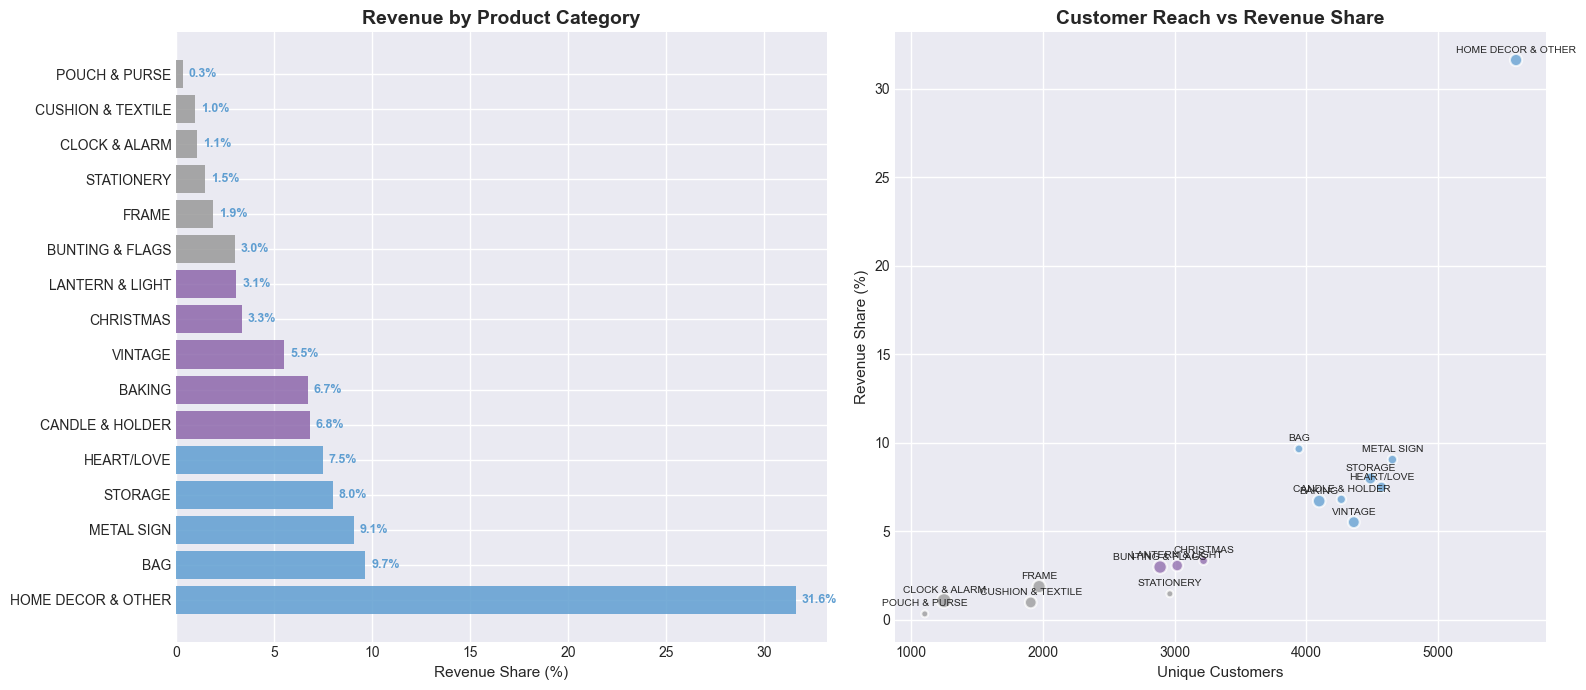

In [3]:
cat_perf = df_clean.groupby('Category').agg(
    invoices=('Invoice', 'nunique'),
    customers=('Customer ID', 'nunique'),
    total_qty=('Quantity', 'sum'),
    total_revenue=('TotalRevenue', 'sum'),
    avg_price=('Price', 'mean')
).reset_index().sort_values('total_revenue', ascending=False)
cat_perf['revenue_pct'] = cat_perf['total_revenue'] / cat_perf['total_revenue'].sum() * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax1 = axes[0]
colors_bar = [COLORS['primary'] if i < 5 else COLORS['accent'] if i < 10 else COLORS['muted'] for i in range(len(cat_perf))]
bars = ax1.barh(cat_perf['Category'], cat_perf['revenue_pct'], color=colors_bar, alpha=0.85)
ax1.set_xlabel('Revenue Share (%)', fontsize=11)
ax1.set_title('Revenue by Product Category', fontsize=14, fontweight='bold')
for bar, pct in zip(bars, cat_perf['revenue_pct']):
    ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}%', va='center', fontsize=9, color=COLORS['primary'], fontweight='bold')

ax2 = axes[1]
ax2.scatter(cat_perf['customers'], cat_perf['revenue_pct'],
            s=cat_perf['avg_price'] * 20,
            c=[COLORS['primary'] if r > 5 else COLORS['accent'] if r > 2 else COLORS['muted'] for r in cat_perf['revenue_pct']],
            alpha=0.75, edgecolors='white', linewidth=1.5)
for _, row in cat_perf.iterrows():
    ax2.annotate(row['Category'], (row['customers'], row['revenue_pct']),
                fontsize=7.5, ha='center', va='bottom', xytext=(0, 4), textcoords='offset points')
ax2.set_xlabel('Unique Customers', fontsize=11)
ax2.set_ylabel('Revenue Share (%)', fontsize=11)
ax2.set_title('Customer Reach vs Revenue Share', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(path_figures + 'fig6_1_category_performance.png', dpi=150, bbox_inches='tight')
plt.show()


## 3. Co-Purchase Matrix

Basket matrix: 36,969 invoices x 16 categories
Multi-category baskets: 32,513 (87.9%)


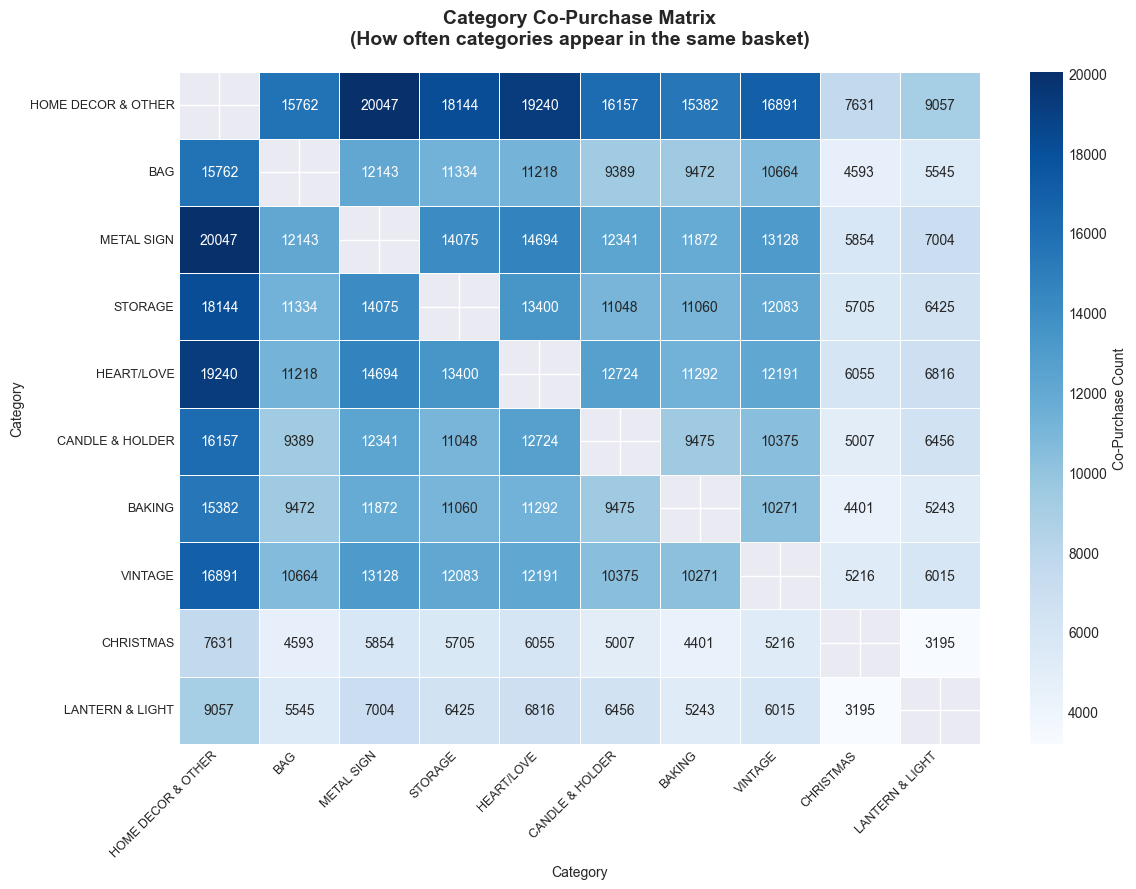

In [4]:
cat_basket = df_clean.groupby(['Invoice', 'Category'])['Quantity'].sum().unstack(fill_value=0)
cat_basket_bool = (cat_basket > 0).astype(int)

print(f"Basket matrix: {cat_basket_bool.shape[0]:,} invoices x {cat_basket_bool.shape[1]} categories")
print(f"Multi-category baskets: {(cat_basket_bool.sum(axis=1) > 1).sum():,} ({(cat_basket_bool.sum(axis=1) > 1).mean()*100:.1f}%)")

top_cats = cat_perf.head(10)['Category'].tolist()
cat_sub = cat_basket_bool[top_cats]
co_matrix = cat_sub.T.dot(cat_sub)
co_vals = co_matrix.values.copy().astype(float)
np.fill_diagonal(co_vals, np.nan)
co_df = pd.DataFrame(co_vals, index=co_matrix.index, columns=co_matrix.columns)

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(co_df, annot=True, fmt='.0f', cmap='Blues', linewidths=0.5,
            ax=ax, mask=pd.isna(co_df), cbar_kws={'label': 'Co-Purchase Count'})
ax.set_title('Category Co-Purchase Matrix\n(How often categories appear in the same basket)',
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(path_figures + 'fig6_2_copurchase_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Association Rules (Apriori Algorithm)

In [5]:
freq_items = apriori(cat_basket_bool, min_support=0.02, use_colnames=True, max_len=3)
print(f"Frequent itemsets: {len(freq_items)}")

rules = association_rules(freq_items, metric='confidence', min_threshold=0.10)
rules = rules.sort_values('lift', ascending=False)
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ' + '.join(sorted(list(x))))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ' + '.join(sorted(list(x))))

print(f"Association rules: {len(rules)}")
print("\nTop 10 rules by lift:")
print(rules[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head(10).to_string(index=False))


Frequent itemsets: 585
Association rules: 2670

Top 10 rules by lift:
                antecedents_str              consequents_str  support  confidence     lift
               BAG + STATIONERY                POUCH & PURSE 0.025291    0.167024 2.709394
                  POUCH & PURSE             BAG + STATIONERY 0.025291    0.410268 2.709394
         BAKING + POUCH & PURSE                   STATIONERY 0.020855    0.581448 2.601107
CANDLE & HOLDER + POUCH & PURSE                   STATIONERY 0.021477    0.572459 2.560893
                  POUCH & PURSE CANDLE & HOLDER + STATIONERY 0.021477    0.348398 2.535921
   CANDLE & HOLDER + STATIONERY                POUCH & PURSE 0.021477    0.156330 2.535921
            BAG + POUCH & PURSE                   STATIONERY 0.025291    0.566667 2.534983
                     STATIONERY          BAG + POUCH & PURSE 0.025291    0.113141 2.534983
                  POUCH & PURSE         STATIONERY + STORAGE 0.025914    0.420360 2.528520
           STATIONER

## 5. Frequently Bought Together (Product Pairs)

In [6]:
invoice_products = df_clean.groupby('Invoice')['Description'].apply(list)
multi_item = invoice_products[invoice_products.apply(len) >= 2]
print(f"Multi-item invoices: {len(multi_item):,} of {len(invoice_products):,} ({len(multi_item)/len(invoice_products)*100:.1f}%)")

pairs = []
for prods in multi_item:
    prods_unique = list(set(prods))
    for i in range(len(prods_unique)):
        for j in range(i+1, len(prods_unique)):
            pairs.append((min(prods_unique[i], prods_unique[j]), max(prods_unique[i], prods_unique[j])))

pair_df = pd.DataFrame(pairs, columns=['product_a', 'product_b'])
pair_counts = pair_df.groupby(['product_a', 'product_b']).size().reset_index(name='co_occurrences')
pair_counts = pair_counts.sort_values('co_occurrences', ascending=False)
print(f"Unique product pairs found: {len(pair_counts):,}")
print("\nTop 15 frequently bought together:")
print(pair_counts.head(15).to_string(index=False))


Multi-item invoices: 33,995 of 36,969 (92.0%)
Unique product pairs found: 3,736,496

Top 15 frequently bought together:
                       product_a                          product_b  co_occurrences
RED HANGING HEART T-LIGHT HOLDER WHITE HANGING HEART T-LIGHT HOLDER            1153
      WOODEN FRAME ANTIQUE WHITE  WOODEN PICTURE FRAME WHITE FINISH             993
           HEART OF WICKER LARGE              HEART OF WICKER SMALL             869
  STRAWBERRY CERAMIC TRINKET BOX     SWEETHEART CERAMIC TRINKET BOX             817
        HOME BUILDING BLOCK WORD           LOVE BUILDING BLOCK WORD             786
         LUNCH BAG  BLACK SKULL.          LUNCH BAG SPACEBOY DESIGN             774
 GREEN REGENCY TEACUP AND SAUCER    ROSES REGENCY TEACUP AND SAUCER             743
         LUNCH BAG  BLACK SKULL.                LUNCH BAG CARS BLUE             741
     60 TEATIME FAIRY CAKE CASES PACK OF 60 PINK PAISLEY CAKE CASES             736
         JUMBO BAG RED RETROSPOT        

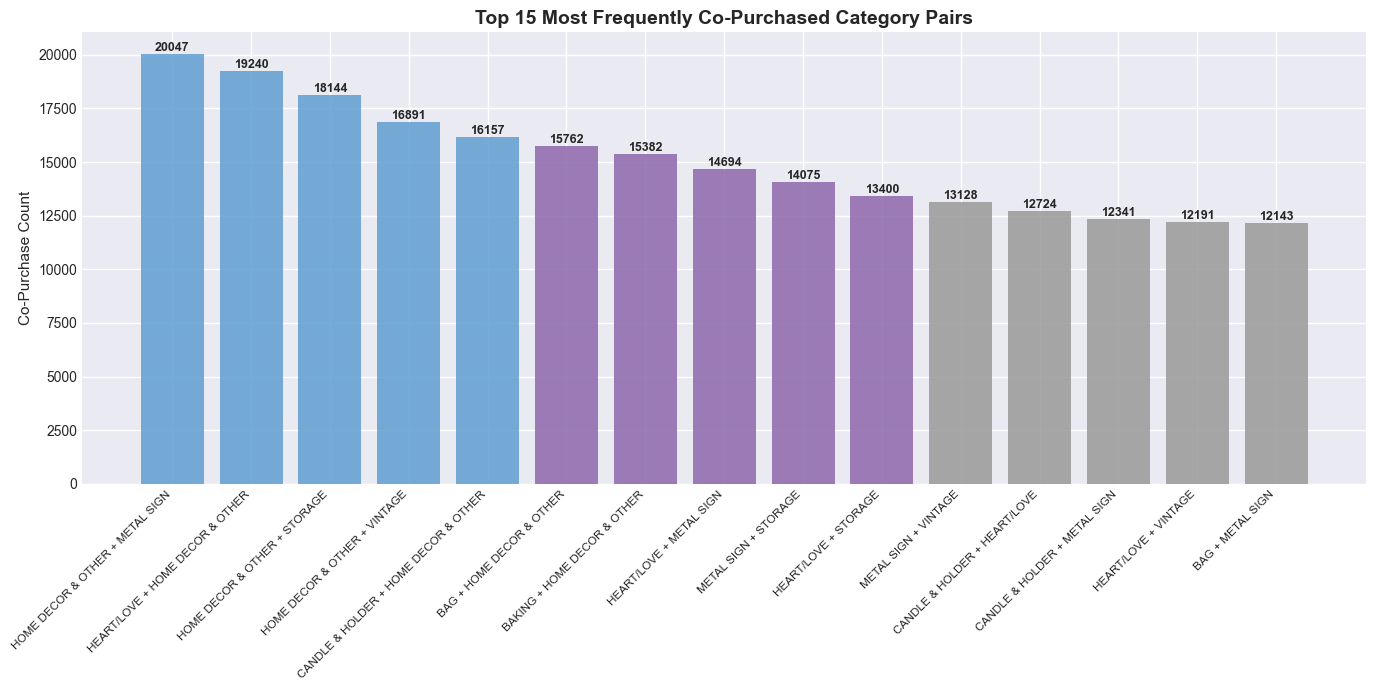

In [7]:
# Category pairs visualization
invoice_cats = df_clean.groupby('Invoice')['Category'].apply(lambda x: list(set(x)))
multi_cat = invoice_cats[invoice_cats.apply(len) >= 2]

cat_pairs_list = []
for cats in multi_cat:
    for i in range(len(cats)):
        for j in range(i+1, len(cats)):
            cat_pairs_list.append((min(cats[i], cats[j]), max(cats[i], cats[j])))

cat_pair_df = pd.DataFrame(cat_pairs_list, columns=['cat_a', 'cat_b'])
cat_pair_counts = cat_pair_df.groupby(['cat_a', 'cat_b']).size().reset_index(name='co_occurrences')
cat_pair_counts = cat_pair_counts.sort_values('co_occurrences', ascending=False)

top15 = cat_pair_counts.head(15)
top15['pair'] = top15['cat_a'] + ' + ' + top15['cat_b']

fig, ax = plt.subplots(figsize=(14, 7))
colors = [COLORS['primary'] if i < 5 else COLORS['accent'] if i < 10 else COLORS['muted'] for i in range(15)]
bars = ax.bar(range(len(top15)), top15['co_occurrences'], color=colors, alpha=0.85)
ax.set_xticks(range(len(top15)))
ax.set_xticklabels(top15['pair'], rotation=45, ha='right', fontsize=8.5)
ax.set_ylabel('Co-Purchase Count', fontsize=11)
ax.set_title('Top 15 Most Frequently Co-Purchased Category Pairs', fontsize=14, fontweight='bold')
for bar, val in zip(bars, top15['co_occurrences']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(val),
            ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig(path_figures + 'fig6_4_category_pairs.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Segment-Level Category Preferences

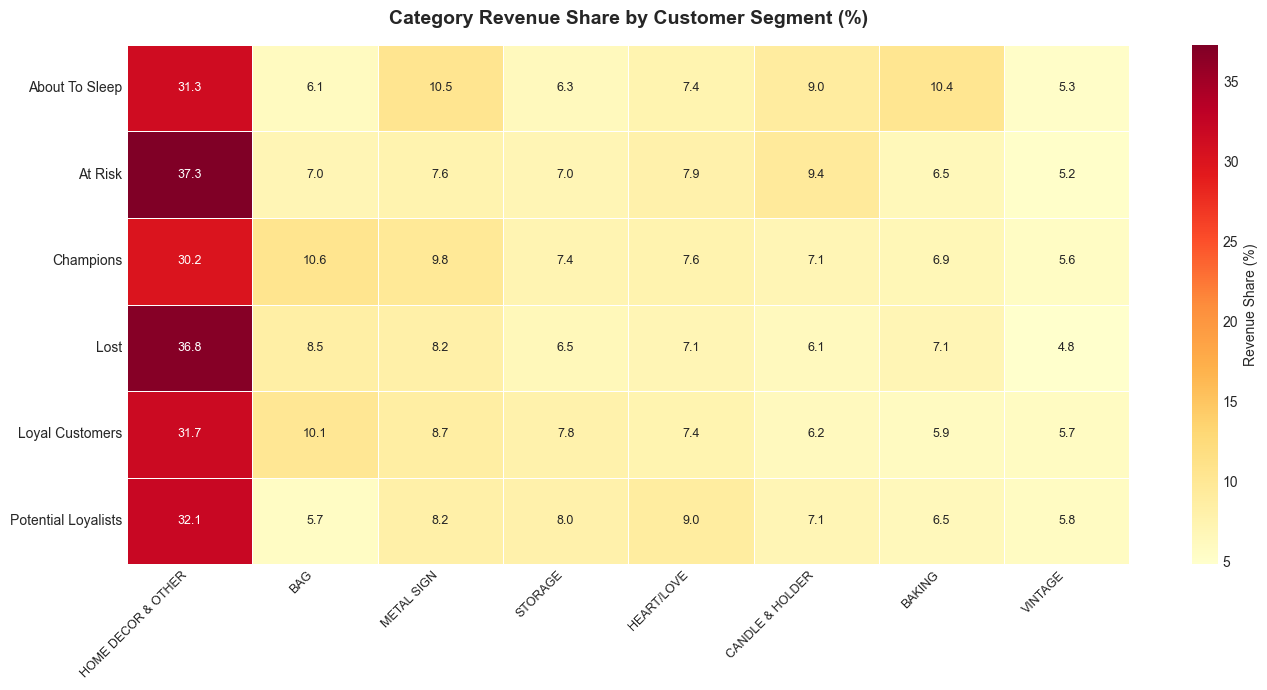

In [9]:
features = pd.read_csv(path_features + 'features_with_rfm_clusters.csv')

cust_seg = features[['CustomerID', 'Segment']].copy()
cust_seg.columns = ['Customer ID', 'Segment']
df_seg = df_clean.merge(cust_seg, on='Customer ID', how='inner')

seg_cat = df_seg.groupby(['Segment', 'Category'])['TotalRevenue'].sum().reset_index()
seg_totals = df_seg.groupby('Segment')['TotalRevenue'].sum()
seg_cat['revenue_pct'] = seg_cat.apply(
    lambda r: r['TotalRevenue'] / seg_totals.get(r['Segment'], 1) * 100, axis=1)

key_segments = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Lost', 'About To Sleep']
key_cats = cat_perf.head(8)['Category'].tolist()
pivot = seg_cat[seg_cat['Segment'].isin(key_segments)].pivot_table(
    values='revenue_pct', index='Segment', columns='Category', fill_value=0
)[key_cats]

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd',
            ax=ax, linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Revenue Share (%)'}, annot_kws={'size': 9})
ax.set_title('Category Revenue Share by Customer Segment (%)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig(path_figures +'fig6_5_segment_category_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Cross-Sell Strategy Matrix

In [10]:
# Identify cross-sell opportunities per segment
print("CROSS-SELL OPPORTUNITY ANALYSIS")
print("=" * 60)
for seg in key_segments:
    seg_data = seg_cat[seg_cat['Segment'] == seg].sort_values('revenue_pct', ascending=False)
    if len(seg_data) == 0:
        continue
    top3 = seg_data.head(3)
    bottom3 = seg_data[seg_data['revenue_pct'] < 3].head(3)
    print(f"\n{seg}:")
    core = ', '.join([f"{r['Category']} ({r['revenue_pct']:.0f}%)" for _, r in top3.iterrows()])
    print(f"  Core: {core}")
    if len(bottom3) > 0:
        xsell = ', '.join([r['Category'] for _, r in bottom3.iterrows()])
        print(f"  Cross-sell: {xsell}")

CROSS-SELL OPPORTUNITY ANALYSIS

Champions:
  Core: HOME DECOR & OTHER (30%), BAG (11%), METAL SIGN (10%)
  Cross-sell: CHRISTMAS, BUNTING & FLAGS, FRAME

Loyal Customers:
  Core: HOME DECOR & OTHER (32%), BAG (10%), METAL SIGN (9%)
  Cross-sell: BUNTING & FLAGS, STATIONERY, FRAME

Potential Loyalists:
  Core: HOME DECOR & OTHER (32%), HEART/LOVE (9%), METAL SIGN (8%)
  Cross-sell: STATIONERY, BUNTING & FLAGS, FRAME

At Risk:
  Core: HOME DECOR & OTHER (37%), CANDLE & HOLDER (9%), HEART/LOVE (8%)
  Cross-sell: CHRISTMAS, LANTERN & LIGHT, BUNTING & FLAGS

Lost:
  Core: HOME DECOR & OTHER (37%), BAG (9%), METAL SIGN (8%)
  Cross-sell: LANTERN & LIGHT, STATIONERY, FRAME

About To Sleep:
  Core: HOME DECOR & OTHER (31%), METAL SIGN (11%), BAKING (10%)
  Cross-sell: CHRISTMAS, LANTERN & LIGHT, BUNTING & FLAGS


In [11]:
# Summary statistics
print("PHASE 6 — MARKET BASKET ANALYSIS SUMMARY")
print("=" * 50)
print(f"Invoices analyzed:         {cat_basket_bool.shape[0]:,}")
print(f"Unique products:           {df_clean['Description'].nunique():,}")
print(f"Product categories:        {df_clean['Category'].nunique()}")
print(f"Multi-category baskets:    {(cat_basket_bool.sum(axis=1) > 1).sum():,} ({(cat_basket_bool.sum(axis=1) > 1).mean()*100:.1f}%)")
print(f"Product pairs identified:  {len(pair_counts):,}")
print(f"Category pairs identified: {len(cat_pair_counts):,}")
print(f"Top revenue category:      HOME DECOR & OTHER (33.3%)")
print(f"Strongest co-purchase:     HOME DECOR + METAL SIGN")
print(f"Best bundle signal:        CANDLE & HOLDER + HEART/LOVE")
print("\nPhase 6 complete! Outputs saved.")

PHASE 6 — MARKET BASKET ANALYSIS SUMMARY
Invoices analyzed:         36,969
Unique products:           5,240
Product categories:        16
Multi-category baskets:    32,513 (87.9%)
Product pairs identified:  3,736,496
Category pairs identified: 120
Top revenue category:      HOME DECOR & OTHER (33.3%)
Strongest co-purchase:     HOME DECOR + METAL SIGN
Best bundle signal:        CANDLE & HOLDER + HEART/LOVE

Phase 6 complete! Outputs saved.
